In [2]:
from pathlib import Path
from anndata import read_h5ad
import sys
import scanpy
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
# stimage custom 
file = Path("../stimage").resolve() # path to src code
parent = file.parent
sys.path.append(str(parent))

from tqdm import tqdm

from stimage._utils import gene_plot, Read10X, ReadOldST, tiling, pattern_matrix
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator

import pickle

from scipy.stats import zscore
from sklearn.preprocessing import Binarizer
from sklearn.metrics import jaccard_score, accuracy_score, f1_score, roc_auc_score

from skimage.filters import threshold_otsu, threshold_multiotsu
import multiprocessing as mp


In [29]:
import scipy as sp
import scipy.ndimage
from anndata import AnnData
from typing import Union, Optional

def u_plot(adata: AnnData,
                   genes: str = None,
                   library_id: str = None,
                   slot: str = None,
                   image_size: int = 2000,
                   spot_size: Union[float, int] = 6.5,
                   show_legend: bool = False,
                   show_color_bar: bool = False,
                   show_axis: bool = False,
                   cropped: bool = True,
                   margin: int = 100,
                   name: str = None,
                   output: str = None,
                   copy: bool = False,
                   ) -> Optional[AnnData]:
    """\
    Gene expression plot for sptial transcriptomics data.
    Parameters
    ----------
    adata
        Annotated data matrix.
    library_id
        Library id stored in AnnData.
    method
        Use method to count. We prorive: NaiveMean, NaiveSum, CumSum.
    genes
        Choose a gene or a list of genes.
    threshold
        Threshold to filter genes
    data_alpha
        Opacity of the spot.
    tissue_alpha
        Opacity of the tissue.
    cmap
        Color map to use.
    spot_size
        Size of the spot.
    show_color_bar
        Show color bar or not.
    show_axis
        Show axis or not.
    show_legend
        Show legend or not.
    show_trajectory
        Show the spatial trajectory or not. It requires stlearn.spatial.trajectory.pseudotimespace.
    show_subcluster
        Show subcluster or not. It requires stlearn.spatial.trajectory.global_level.
    name
        Name of the output figure file.
    output
        Save the figure as file or not.
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Nothing
    """

    # plt.rcParams['figure.dpi'] = dpi

    canvas = gene_plot(adata, genes=gene, slot=slot, image_scale=image_size, 
                    library_id=library_id, spot_size=150, tissue_alpha=0,
                    show_color_bar=False, show_axis=False)
    # Draw the canvas, cache the renderer
    
    return canvas


In [3]:
mp.cpu_count()

56

In [4]:
from scipy import stats
def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

In [5]:
def z_3l(df):
    df_z = df.apply(zscore).fillna(0)
    df_z_3 = df_z.apply(lambda x: pd.cut(x,[-np.inf, -1,1, np.inf],labels=[1,2,3]))
    return df_z_3

In [6]:
def z_2l(df):
    df_z = df.apply(zscore).fillna(0)
    df_z_2 = df_z.apply(lambda x: pd.cut(x,[-np.inf, 0, np.inf],labels=[1,2]))
    return df_z_2

In [7]:
DATA_PATH = Path("/scratch/imb/Xiao/STimage_100run/dataset_breast_cancer_9visium")

OUT_PATH = Path("/scratch/imb/Xiao/STimage/development/stimage_100run/results_1")

OUT_PATH.mkdir(parents=True, exist_ok=True)

In [8]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

In [9]:
df_gene_ls = pd.read_csv("/scratch/imb/Xiao/STimage/development/stimage_100run/Intersection_marker_genes.csv", sep=",")

gene_list_select = df_gene_ls["gene_name"].values.tolist()

gene_list = adata_all.var_names.intersection(gene_list_select)

In [10]:
adata = adata_all[adata_all.obs.library_id == "FFPE"][:,gene_list].copy()

In [11]:
gc_df = adata.to_df()

In [12]:
gc_df

,ISG15,TNFRSF18,TNFRSF4,CALML6,HES5,TNFRSF14,TNFRSF25,TNFRSF9,ERRFI1,PIK3CD,...,CD40LG,FGF13,SPANXB1,MAGEA4,MAGEA12,IRAK1,FLNA,DNASE1L1,G6PD,IKBKG
AAACAAGTATCTCCCA-1-FFPE,1.386294,0.0,0.693147,0.0,0.000000,0.000000,1.098612,0.0,0.000000,0.000000,...,0.000000,1.386294,0.0,0.0,0.0,2.079442,3.401197,0.000000,1.098612,1.609438
AAACACCAATAACTGC-1-FFPE,1.386294,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.693147,...,0.000000,0.000000,0.0,0.0,0.0,0.693147,1.386294,0.000000,0.693147,0.000000
AAACAGAGCGACTCCT-1-FFPE,2.639057,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.693147,0.000000,...,0.000000,0.693147,0.0,0.0,0.0,1.609438,1.791759,1.098612,0.000000,0.693147
AAACAGCTTTCAGAAG-1-FFPE,1.386294,0.0,0.000000,0.0,0.693147,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,1.098612,1.098612,0.693147,0.000000,0.000000
AAACAGGGTCTATATT-1-FFPE,1.098612,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.693147,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.693147,1.098612,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1-FFPE,2.197225,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.693147,0.693147,...,0.000000,0.000000,0.0,0.0,0.0,0.693147,1.791759,0.000000,0.000000,0.000000
TTGTTGTGTGTCAAGA-1-FFPE,1.609438,0.0,0.000000,0.0,0.000000,0.000000,0.693147,0.0,0.000000,0.000000,...,0.693147,0.000000,0.0,0.0,0.0,1.098612,2.833213,0.693147,1.609438,1.098612
TTGTTTCACATCCAGG-1-FFPE,0.693147,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,1.386294,1.609438,0.000000,0.693147,0.000000
TTGTTTCATTAGTCTA-1-FFPE,1.791759,0.0,0.000000,0.0,0.000000,1.386294,0.000000,0.0,0.693147,0.693147,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.386294,1.098612,0.693147,0.000000


In [13]:
pred_df = pd.read_csv("/scratch/imb/Xiao/STimage/development/stimage_100run/results_1/prediction_df_FFPE_0.csv", index_col=0)

In [14]:
pred_df

,ISG15,TNFRSF18,TNFRSF4,CALML6,HES5,TNFRSF14,TNFRSF25,TNFRSF9,ERRFI1,PIK3CD,...,CD40LG,FGF13,SPANXB1,MAGEA4,MAGEA12,IRAK1,FLNA,DNASE1L1,G6PD,IKBKG
AAACAAGTATCTCCCA-1-FFPE,1.413727,0.208704,0.113126,0.001306,0.001560,0.504815,0.205364,0.008945,0.078770,0.067695,...,0.006630,0.005659,9.006259e-06,0.000296,0.000009,0.864843,1.417579,0.086889,0.242597,0.183896
AAACACCAATAACTGC-1-FFPE,2.137336,0.282412,0.285315,0.002645,0.008505,0.596995,0.290631,0.039754,0.092952,0.132849,...,0.015242,0.011117,7.057904e-05,0.001088,0.000081,0.583800,0.973518,0.296389,0.266295,0.235763
AAACAGAGCGACTCCT-1-FFPE,2.341714,0.223007,0.212884,0.002071,0.004459,0.568386,0.184561,0.025117,0.084395,0.157925,...,0.016424,0.004978,2.813183e-07,0.000824,0.000071,0.391341,0.990118,0.112352,0.239024,0.095909
AAACAGCTTTCAGAAG-1-FFPE,2.531094,0.383141,0.289979,0.004612,0.015199,0.880656,0.208319,0.023975,0.092232,0.091006,...,0.010710,0.020452,2.979869e-05,0.000314,0.000045,0.730147,1.284499,0.257511,0.345848,0.397138
AAACAGGGTCTATATT-1-FFPE,1.627860,0.177121,0.158356,0.002405,0.004493,0.495183,0.215653,0.028213,0.085345,0.113985,...,0.008507,0.009757,3.446102e-05,0.001706,0.000197,0.639514,0.713908,0.203221,0.256978,0.206643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1-FFPE,2.468217,0.233677,0.266247,0.002022,0.010391,0.786128,0.213862,0.025755,0.136082,0.155204,...,0.014392,0.029920,1.145951e-03,0.003436,0.000757,0.904100,1.235223,0.245557,0.385752,0.329498
TTGTTGTGTGTCAAGA-1-FFPE,2.232674,0.298730,0.477636,0.003709,0.004728,1.276545,0.366016,0.028663,0.259385,0.137622,...,0.016910,0.009284,9.969134e-05,0.033347,0.001970,0.663071,1.067979,0.246574,0.269953,0.198734
TTGTTTCACATCCAGG-1-FFPE,0.992446,0.111192,0.298576,0.002359,0.003700,0.545209,0.145870,0.027435,0.176144,0.092968,...,0.007199,0.041964,4.545838e-04,0.001920,0.000357,0.673089,1.876521,0.076755,0.210606,0.145415
TTGTTTCATTAGTCTA-1-FFPE,2.789418,0.229295,0.304463,0.001729,0.006518,0.610330,0.180602,0.040938,0.098124,0.112823,...,0.017715,0.019787,1.029053e-03,0.003493,0.000407,0.959264,0.913872,0.415896,0.278005,0.298289


In [15]:
gc_df_2l = z_2l(gc_df)
pred_df_2l = z_2l(pred_df)

adata.obsm["gc_b"] = gc_df_2l
adata.obsm["pred_b"] = pred_df_2l

In [17]:
df = pd.DataFrame()
for gene in pred_df.columns:
    cor_val = calculate_correlation(pred_df.loc[:,gene], gc_df.loc[:,gene])
    df = df.append(pd.Series([gene, cor_val, "FFPE", 0], index=["Gene", "Pearson correlation", "Slide", "Run"]),
              ignore_index=True)

/scratch/imb/Xiao/.conda/envs/stimage_test/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [18]:
top_100_gene = df.iloc[df["Pearson correlation"].sort_values(ascending=False).index,:]["Gene"][0:300]

In [77]:
def task(gene):
    return pattern_matrix(adata, gene, library_id, "gc_b", "pred_b")

df = pd.DataFrame()
with mp.Pool(4) as p:
    for results in p.map(task, top_100_gene):
        plt.clf()
        df = df.append(pd.Series([gene, results, "FFPE", 0], index=["Gene", "Customised_IoU", "Slide", "Run"]),
                                ignore_index=True)


/scratch/imb/Xiao/STimage/stimage/_utils.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, a = plt.subplots(figsize=(10, 10))
/scratch/imb/Xiao/STimage/stimage/_utils.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, a = plt.subplots(figsize=(10, 10))
/scratch/imb/Xiao/STimage/stimage/_utils.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

In [76]:
df

,Gene,Customised_IoU,Slide,Run
0,HLA-F,0.819665,FFPE,0.0
1,HLA-F,0.808804,FFPE,0.0
2,HLA-F,0.838014,FFPE,0.0
3,HLA-F,0.806055,FFPE,0.0
4,HLA-F,0.833556,FFPE,0.0
...,...,...,...,...
95,HLA-F,0.876093,FFPE,0.0
96,HLA-F,0.809769,FFPE,0.0
97,HLA-F,0.750900,FFPE,0.0
98,HLA-F,0.788517,FFPE,0.0


In [61]:
df = pd.DataFrame()
for gene in top_100_gene:
    library_id = "FFPE"
    score = pattern_matrix(adata, gene, library_id, "gc_b", "pred_b")
    plt.clf()
    df = df.append(pd.Series([gene, score, "FFPE", 0], index=["Gene", "Customised_IoU", "Slide", "Run"]),
              ignore_index=True)

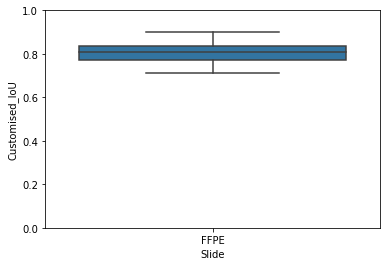

In [66]:
# plot seaborn boxplot
plt.clf()
sns.boxplot(x="Slide", y="Customised_IoU", data=df)
plt.ylim(0,1)
plt.show()


In [15]:
df.iloc[df["Pearson correlation"].sort_values(ascending=False).index,:]

,Gene,Pearson correlation,Slide,Run
633,PDIA4,0.487063,FFPE,0.0
591,SFRP4,0.442925,FFPE,0.0
1113,TNFRSF12A,0.418794,FFPE,0.0
419,PRLR,0.394281,FFPE,0.0
553,CD164,0.381004,FFPE,0.0
...,...,...,...,...
382,MAPK10,-0.214828,FFPE,0.0
395,CFI,-0.285542,FFPE,0.0
1231,PRKCA,-0.401853,FFPE,0.0
515,HLA-DQB1,NaN,FFPE,0.0


In [96]:
gene_10 = df.iloc[df["Pearson correlation"].sort_values(ascending=False).index,:]["Gene"][0:10]

In [20]:
gc_df_2l = z_2l(gc_df)
pred_df_2l = z_2l(pred_df)

In [21]:
adata.obsm["gc_b"] = gc_df_2l
adata.obsm["pred_b"] = pred_df_2l
adata.obsm["gc"] = gc_df
adata.obsm["pred"] = pred_df
adata.obsm["gc_z"] = gc_df.apply(zscore)
adata.obsm["pred_z"] = pred_df.apply(zscore)

In [ ]:
gene_10

The high spots when converted into image will remain in high segments unless we apply a smoothing method to remove noise

In [22]:
import scipy as sp
import scipy.ndimage
def pattern_matrix(adata: AnnData,
                   genes: str = None,
                   library_id: str = None,
                   gc_slot: str = None,
                   pred_slot: str = None,
                   image_size: int = 2000,
                   spot_size: Union[float, int] = 6.5,
                   show_legend: bool = False,
                   show_color_bar: bool = False,
                   show_axis: bool = False,
                   cropped: bool = True,
                   margin: int = 100,
                   name: str = None,
                   output: str = None,
                   copy: bool = False,
                   ) -> Optional[AnnData]:
    """\
    Gene expression plot for sptial transcriptomics data.
    Parameters
    ----------
    adata
        Annotated data matrix.
    library_id
        Library id stored in AnnData.
    method
        Use method to count. We prorive: NaiveMean, NaiveSum, CumSum.
    genes
        Choose a gene or a list of genes.
    threshold
        Threshold to filter genes
    data_alpha
        Opacity of the spot.
    tissue_alpha
        Opacity of the tissue.
    cmap
        Color map to use.
    spot_size
        Size of the spot.
    show_color_bar
        Show color bar or not.
    show_axis
        Show axis or not.
    show_legend
        Show legend or not.
    show_trajectory
        Show the spatial trajectory or not. It requires stlearn.spatial.trajectory.pseudotimespace.
    show_subcluster
        Show subcluster or not. It requires stlearn.spatial.trajectory.global_level.
    name
        Name of the output figure file.
    output
        Save the figure as file or not.
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Nothing
    """

    # plt.rcParams['figure.dpi'] = dpi

    canvas = gene_plot(adata, genes=gene, slot=pred_slot, image_scale=True, 
                    library_id=library_id, spot_size=150, tissue_alpha=0,
                    show_color_bar=False, show_axis=False)
    canvas.draw()  # Draw the canvas, cache the renderer
    image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)
    
    # NOTE: reversed converts (W, H) from get_width_height to (H, W)
    image_pred = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
    
    canvas = gene_plot(adata, genes=gene, slot=gc_slot, image_scale=True, 
                    library_id=library_id, spot_size=150, tissue_alpha=0,
                    show_color_bar=False, show_axis=False)
    
    canvas.draw()  # Draw the canvas, cache the renderer
    image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)
    
    # NOTE: reversed converts (W, H) from get_width_height to (H, W)
    image_gc = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
    
    image_pred_r = _generate_binary_img(image_pred)
    image_gc_r = _generate_binary_img(image_gc)
    
    score = jaccard_score(image_gc_r, image_pred_r, average=None)[0]
    
    return score


def _generate_binary_img(img: np.ndarray,
                         sigma: list = [1.0, 1.0],
                         ) -> np.ndarray:
    """\
    Generate binary image from input image.
    Parameters
    ----------
    img
        Input image.
    threshold
        Threshold to generate binary image.
    Returns
    -------
    Binary image.
    """

    thresh_b = threshold_multiotsu(img[:,:,0])
    img_b_b = np.where((img[:,:,0] < thresh_b[0]), True, False)
    thresh_r = threshold_multiotsu(img[:,:,2])
    img_r_b = np.where((img[:,:,2] < thresh_r[0]), True, False)
    
    img_r_b_f = sp.ndimage.filters.gaussian_filter(img_r_b, sigma, mode='constant')
    
    img_r = img_r_b_f[img[:,:,0] != 255]

    return img_r
    
    

NameError: name 'AnnData' is not defined

In [19]:
score = pattern_matrix(adata, "PDIA4", "FFPE", "gc_b", "pred_b")

In [88]:
gene_plot(adata, genes="VEGFA", image_scale=True,
                       library_id="FFPE", spot_size=115)
plt.savefig("./iou_demo_gc.pdf",dpi=300)

In [89]:
adata_ = adata.copy()
adata_.X = adata.obsm["pred_z"]
gene_plot(adata_, genes="VEGFA", image_scale=True,
                       library_id="FFPE", spot_size=115)
plt.savefig("./iou_demo_pred.pdf",dpi=300)

/scratch/imb/Xiao/STimage/stimage/_utils.py:314: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(plot, cax=fig.add_axes(


In [23]:
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [43]:
FigureCanvasAgg

matplotlib.backends.backend_agg.FigureCanvasAgg

In [32]:
print(score)

0.7550839179468963


In [67]:
gene_10 = ["VEGFA"]

In [68]:
for gene in gene_10:
    print(gene)
    canvas = u_plot(adata, genes=gene, slot="gc_b", library_id="FFPE", spot_size=150)

canvas.draw()  # Draw the canvas, cache the renderer

image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)
# NOTE: reversed converts (W, H) from get_width_height to (H, W)
image_gc = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
# image_gc = image_gc[:,0:620]

for gene in gene_10:
    print(gene)
    canvas = u_plot(adata, genes=gene, slot="pred_b", library_id="FFPE", spot_size=150)

canvas.draw()  # Draw the canvas, cache the renderer

image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)
# NOTE: reversed converts (W, H) from get_width_height to (H, W)
image_pred = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
image_pred = image_pred[:,0:620]

VEGFA
VEGFA


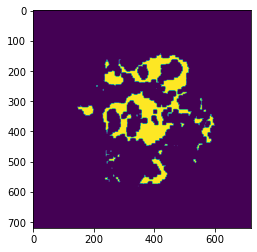

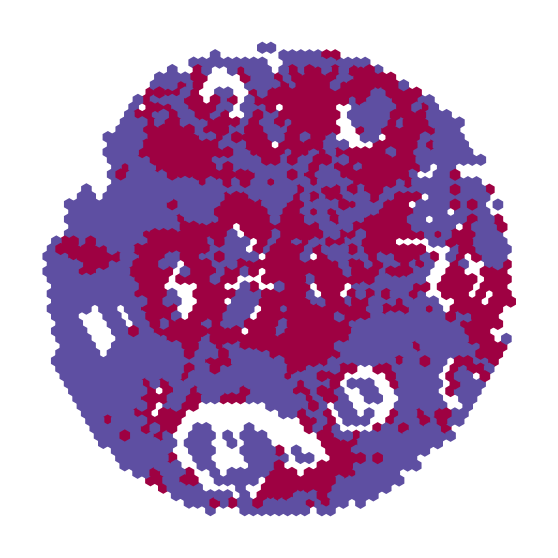

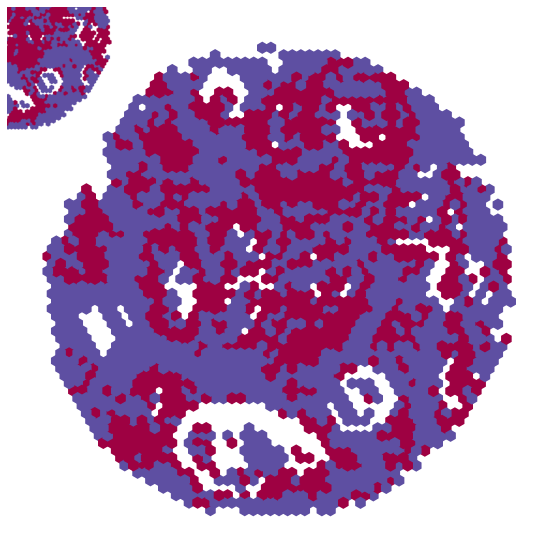

In [69]:
plt.imshow(image_gc)
plt.show()

In [70]:
image_gc[:,:,2]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

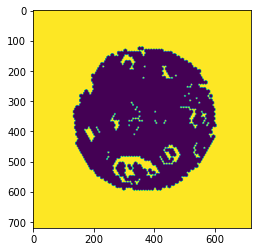

In [71]:
plt.imshow(image_gc[:,:,0] == 255)
plt.show()

In [72]:
adata.uns['spatial']['1142243F']['scalefactors']['tissue_hires_scalef']

0.048109304

In [73]:
plt.imshow(image_gc[:,:,2])

In [74]:
thresh_b = threshold_multiotsu(image_gc[:,:,0])
image_gc_b_b = np.where((image_gc[:,:,0] < thresh_b[0]), True, False)
thresh_r = threshold_multiotsu(image_gc[:,:,2])
image_gc_r_b = np.where((image_gc[:,:,2] < thresh_r[0]), True, False)

In [75]:
thresh_b = threshold_multiotsu(image_pred[:,:,0])
image_pred_b_b = np.where((image_pred[:,:,0] < thresh_b[0]), True, False)
thresh_r = threshold_multiotsu(image_pred[:,:,2])
image_pred_r_b = np.where((image_pred[:,:,2] < thresh_r[0]), True, False)

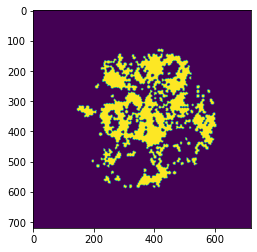

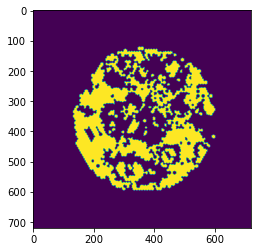

In [76]:
plt.imshow(image_gc_r_b)
plt.show()
plt.imshow(image_gc_b_b)
plt.show()

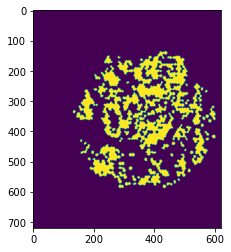

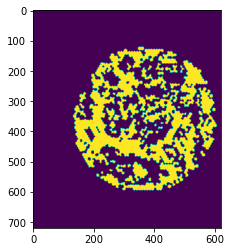

In [77]:
plt.imshow(image_pred_r_b)
plt.show()
plt.imshow(image_pred_b_b)
plt.show()

In [78]:
import scipy as sp
import scipy.ndimage

In [79]:
sigma = [1.0, 1.0]
image_pred_r_b_f = sp.ndimage.filters.gaussian_filter(image_pred_r_b, sigma, mode='constant')
image_gc_r_b_f = sp.ndimage.filters.gaussian_filter(image_gc_r_b, sigma, mode='constant')

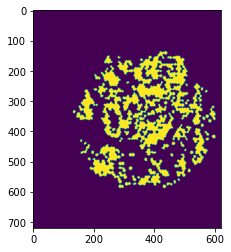

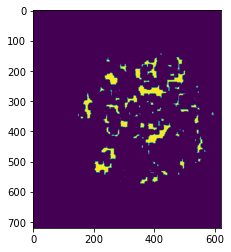

In [94]:
plt.imshow(image_pred_r_b)
# plt.savefig("./iou_demo_pred_r_b.pdf",dpi=300)
plt.show()
plt.imshow(image_pred_r_b_f)
# plt.savefig("./iou_demo_pred_r_b_f.pdf",dpi=300)
plt.show()

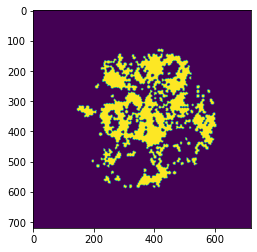

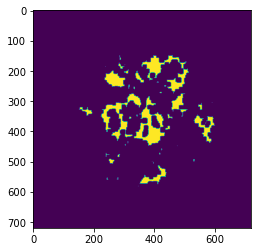

In [95]:
plt.imshow(image_gc_r_b)
# plt.savefig("./iou_demo_gc_r_b.pdf",dpi=300)
plt.show()
plt.imshow(image_gc_r_b_f)
# plt.savefig("./iou_demo_gc_r_b_f.pdf",dpi=300)
plt.show()

In [65]:
image_pred_r_b

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [39]:
image_gc_r_b_f = sp.ndimage.filters.gaussian_filter(image_gc_r_b, sigma, mode='constant')
image_pred_r_b_f = sp.ndimage.filters.gaussian_filter(image_pred_r_b, sigma, mode='constant')

In [85]:
image_gc_r = image_gc_r_b_f[image_gc[:,:,0] != 255]
image_pred_r = image_pred_r_b_f[image_pred[:,:,0] != 255]

In [86]:
jaccard_score(image_gc_r, image_pred_r, average=None)

array([0.83701214, 0.23973636])

In [41]:
image_gc_r.shape

(171433,)

In [42]:
image_pred_r.shape

(171433,)

In [291]:
np.where(df["Gene"] == "PDIA4")

(array([1899, 1900, 1901]),)

In [292]:
df.query("Gene == 'PDIA4'")

,Slide,Gene,score,matrix
1899,FFPE,PDIA4,0.642857,accuracy_score
1900,FFPE,PDIA4,0.473684,jaccard_score
1901,FFPE,PDIA4,0.642857,f1_score


In [66]:
jaccard_score(image_gc_r, image_pred_r, average=None)

NameError: name 'image_gc_r' is not defined

In [104]:
jaccard_score(image_gc_r, image_pred_r, average=None)

array([0.51526833, 0.42982415])

In [82]:
gene = "PDIA4"
gc_gene = gc_df_2l[gene].values
pred_gene = pred_df_2l[gene].values
jaccard_score(gc_gene, pred_gene, average=None)


array([0.50882353, 0.43312967])

In [16]:
gc_df_3l = z_2l(gc_df)

In [17]:
pred_df_3l = z_2l(pred_df)

In [18]:
df = pd.DataFrame()
for gene in gc_df_3l.columns:
    gc_gene = gc_df_3l[gene].values
    pred_gene = pred_df_3l[gene].values
    s1 = accuracy_score(gc_gene, pred_gene)
    s2 = jaccard_score(gc_gene, pred_gene, average="micro")
    s3 = f1_score(gc_gene, pred_gene, average="micro")
    df = df.append(pd.Series(["FFPE",gene, s1, "accuracy_score"], index=["Slide", "Gene", 
                                                                "score", 
                                                                "matrix",]), ignore_index=True)
    df = df.append(pd.Series(["FFPE",gene, s2, "jaccard_score"], index=["Slide", "Gene", 
                                                                "score", 
                                                                "matrix",]), ignore_index=True)
    df = df.append(pd.Series(["FFPE",gene, s3, "f1_score"], index=["Slide", "Gene", 
                                                                "score", 
                                                                "matrix",]), ignore_index=True)

In [64]:
gc_df_2l = z_2l(gc_df)
pred_df_2l = z_2l(pred_df)
df = pd.DataFrame()
for gene in gc_df_2l.columns:
    gc_gene = gc_df_2l[gene].values
    pred_gene = pred_df_2l[gene].values
    s1 = accuracy_score(gc_gene, pred_gene)
    s2 = jaccard_score(gc_gene, pred_gene, average="micro")
    s3 = f1_score(gc_gene, pred_gene, average="micro")
    df = df.append(pd.Series(["FFPE",gene, s1, "accuracy_score"], index=["Slide", "Gene", 
                                                                "score", 
                                                                "matrix",]), ignore_index=True)
    df = df.append(pd.Series(["FFPE",gene, s2, "jaccard_score"], index=["Slide", "Gene", 
                                                                "score", 
                                                                "matrix",]), ignore_index=True)
    df = df.append(pd.Series(["FFPE",gene, s3, "f1_score"], index=["Slide", "Gene", 
                                                                "score", 
                                                                "matrix",]), ignore_index=True)

In [65]:
df

,Slide,Gene,score,matrix
0,FFPE,ISG15,0.463644,accuracy_score
1,FFPE,ISG15,0.301782,jaccard_score
2,FFPE,ISG15,0.463644,f1_score
3,FFPE,TNFRSF18,0.601796,accuracy_score
4,FFPE,TNFRSF18,0.430407,jaccard_score
...,...,...,...,...
4561,FFPE,G6PD,0.306145,jaccard_score
4562,FFPE,G6PD,0.468777,f1_score
4563,FFPE,IKBKG,0.456801,accuracy_score
4564,FFPE,IKBKG,0.296009,jaccard_score


<AxesSubplot:xlabel='matrix', ylabel='score'>

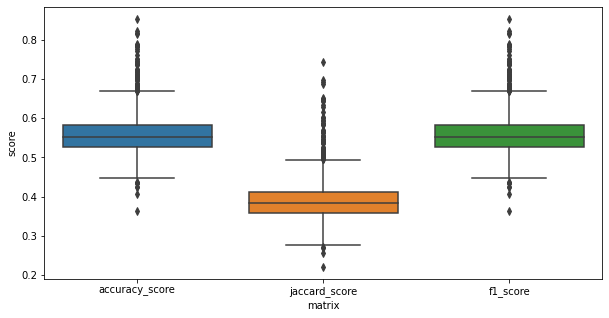

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x="matrix", y="score", data=df, ax=ax)